# Homework09

Exercises to practice dimensionality reduction with PCA

## Goals

- Add unsupervised pre-processing to our ML flow: encode -> normalize -> pre-process -> train -> evaluate
- Build an intuition for PCA and when/how to use it
- Understand the benefits of dimensionality reduction

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [ ]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/Homework07/raw/main/Homework07_utils.pyc

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [ ]:
import PIL.Image as PImage

from os import listdir, path

from data_utils import PCA, RandomForestClassifier

from image_utils import get_pixels, make_image

from Homework07_utils import CamUtils

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same one we used in `Homework07`. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [ ]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [ ]:
# TODO: check and see what is inside the list here
print(train_files[0])
print(len(train_files))

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [ ]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [ ]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print(label_data[:10])
print(train_files[:10])

Like in `Homework07`, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

In [ ]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did in Homewokr07 with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `Homework07`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [ ]:

# import matplotlib.pyplot as plt
# component_numbers = list(range(2,20,2))
# variances = []
# for n in component_numbers:
#     pca = PCA(n_components = n)
#     cam_pca_df = pca.fit_transform(pixel_data)
#     variances.append(pca.explained_variance())
#     print("COMPONENTS:", n, " VARIANCE:", pca.explained_variance())
# plt.plot(component_numbers,variances )

# TODO: run PCA, get DataFrame
pca = PCA(n_components = 10)
cam_pca_df = pca.fit_transform(pixel_data)

# TODO: add "label" column
cam_pca_df['label']=label_data

# TODO: print variance
print(pca.explained_variance())
# print(pca.components)

# TODO: take a look at the first 5 row
# print(cam_pca_df[:5])


### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

<span style="color:green;">With 10 components i got a variance of .78. With 5, I got a variance of .64 which means that less of the origional is explained by the reduced data. I then decided to try a range of components and plot them to see if at a certain point it starts to improve less. What I noticed is the variance starts to taper off as the number of components increases, so I think using n_components =8 is a solid choice. It corresponds to a .74 variance</span>

### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.

In [ ]:
# TODO: reconstruct image at index 0
pixel_data2 = pca.inverse_transform(cam_pca_df)
print(pixel_data2.__class__)
print(pixel_data2.shape)
# TODO: reconstruct image at index 10
display(make_image(pixel_data2.iloc[0], width=256))
display(make_image(pixel_data2.iloc[10], width=256))

The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [48]:
# TODO: create a classifier
rf = RandomForestClassifier()

# TODO: split input and output features
input_features = [c for c in cam_pca_df.columns if c!= 'label']
output_feature = 'label'

# TODO: fit the model
rf.fit(cam_pca_df[input_features],cam_pca_df[output_feature] )

# TODO: run predictions
predicted_train = rf.predict(cam_pca_df[input_features])

### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [49]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, predicted_train)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

### Run on Test set

Now we'll open the image files inside the `./data/image/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [51]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir('./data/image/0801-500/test') if f.endswith('.jpg')]

# TODO: check its length and content
print(len(test_files))
print(test_files[:3])

1573
['15930604.jpg', '15087941.jpg', '11041879.jpg']


We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [52]:
test_pixel_data = []

for fname in test_files:
  img = PImage.open(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(get_pixels(img))

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [56]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one
test_dim_red_data = pca.transform(test_pixel_data)


It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

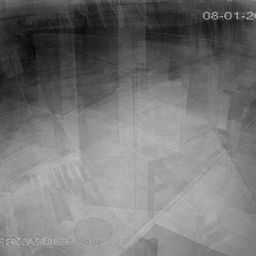

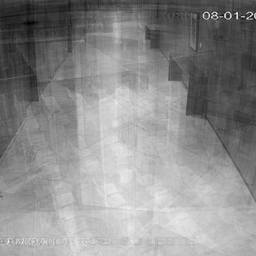

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,96.158039,99.560147,101.499205,98.425751,101.538230,108.399058,110.277631,108.434490,105.792546,106.120316,...,129.040912,127.736784,123.914287,125.173800,125.351944,124.353861,123.515237,122.322757,120.908423,121.124375
1,40.211750,34.531407,31.656542,29.556340,28.504229,25.943086,23.452876,26.142207,29.070178,34.245830,...,151.083595,151.339972,154.912829,157.183413,159.388022,160.683839,161.172587,161.378770,163.302776,159.351348
2,162.781300,164.607216,166.260055,165.909880,170.175678,170.934718,168.088349,168.816769,164.701479,161.517839,...,172.601765,174.286084,170.799092,173.266275,175.324534,176.078051,176.143514,174.823702,171.675129,170.378520
3,60.088704,60.997829,56.218156,60.437396,67.650735,68.681396,68.518361,64.195009,64.701999,67.053024,...,174.129601,173.749772,171.617606,171.627297,172.167787,172.211938,171.741132,171.299289,171.411349,170.615451
4,102.086084,98.531189,95.405922,101.664359,102.784307,101.715494,104.181886,104.078340,107.865412,110.911016,...,154.648496,151.986389,150.582599,150.503337,149.281188,149.259757,148.200836,146.165867,147.789072,144.314582


In [59]:
# TODO: reconstruct one or two images
pixels_test2 = pca.inverse_transform(test_dim_red_data)
display(make_image(pixels_test2.iloc[0], width = 256))
display(make_image(pixels_test2.iloc[3], width = 256))
# TODO: take a look at the first 5 rows
pixels_test2[:5]

### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

<span style="color:green;">Test data tends to work worse than train data since we didn't train/fit to that data. It's using the training data to fit this model, so it doesn't have any of those test images in data i,e its trying to fit our test data to other images so itll look more noisy
</span>



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [60]:
# TODO: run classifier. This is the same classifier already fitted on the train data above
test_prediciton = rf.predict(test_dim_red_data)
# TODO: get accuracy
CamUtils.classification_accuracy(test_files, test_prediciton)

0.926255562619199

### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to the classification model from <code>Homework07</code>? They can both be tuned to perform well, but how many features did we need last time in order to get an accuracy comparable to this?
</span>

<span style="color:green;">The accuracy is .92 which is pretty good. The training accuracy was 1 which is better. We used 8 features, we could improve our test data by plaing with this value. Potentially training on less features might make the training accuracy lower but testing accuracy higher because of more generalizability.</span>